Consigna: 

a) Para el candidato asignado (FIT), visualizar la relación entre la variable del censo asignada
y el porcentaje de votos. El objetivo es cruzar los datos electorales con el Censo 2010
y sus respectivas geometrías. Interpretar politológicamente los resultados a nivel
circuito electoral. También deberá estar acompañado por visualizaciones.

Para tener en cuenta: recuerden que los radios censales y los circuitos electorales no
tienen la misma geometría, por la que deberán joinear. Para ello harán uso de una
tabla intermedia llamada “rosetta”.

P03 Edad Grupo 2

### Importamos las librerías

In [1]:
import pandas as pd, matplotlib.pyplot as plt, geopandas as gpd, contextily as ctx, numpy as np

# Armamos el DataFrame unificado con los datos del censo, de las elecciones, y sus correspondientes datos geográficos

## Censo

### Importamos los .csv del censo
(si están comprimidos hay que extraerlos)

In [2]:
censo_persona = pd.read_csv(r'../censo2010/persona.csv')
censo_persona = censo_persona.drop(
    columns=["P01", "P05", "P06", "P07", "P12", "P08", "P09", "P10", "CONDACT"], axis=1)

censo_hogar = pd.read_csv(r'../censo2010/hogar.csv')
censo_hogar = censo_hogar.drop(
    columns=["H05", "H06", "H07", "H08", "H09", "H10", "H11", "H12", "H13", "H14", "H15", "H16", "H19A", "H19B", "H19C",
             "H19D", "PROP", "INDHAC"
             ], axis=1)

censo_vivienda = pd.read_csv(r'../censo2010/vivienda.csv')
censo_vivienda = censo_vivienda.drop(
    columns=[
        "TIPVV", "V01", "V02", "V00", "URP", "INCALSERV", "INMAT", "MUNI", "LOCAL", "INCALCONS", "TOTHOG"
    ], axis=1)

censo_radio = pd.read_csv(r'../censo2010/radio.csv')

censo_fraccion = pd.read_csv(r'../censo2010/frac.csv')

censo_dpto = pd.read_csv(r'../censo2010/dpto.csv')
censo_dpto = censo_dpto.drop(
    columns=["IDDPTO"], axis=1)

censo_prov = pd.read_csv(r'../censo2010/prov.csv')
censo_prov = censo_prov.drop(
    columns=["CPV2010_REF_ID", "IDPROV", "PROV", "NOMPROV"], axis=1)

### Unimos las tablas del censo de radio en adelante (radio, fracción, comuna y provincia)

In [3]:
censo_reducido = pd.merge(censo_radio, censo_fraccion, on="FRAC_REF_ID")
censo_reducido = pd.merge(censo_reducido, censo_dpto, on="DPTO_REF_ID")
censo_reducido = pd.merge(censo_reducido, censo_prov, on="PROV_REF_ID")

### Creamos una columna vacía con el nombre LINK

In [4]:
censo_reducido = censo_reducido.assign(LINK="")

### Agregamos la data a la columna LINK en censo_reducido

In [5]:
dato = 0

for fila in range(0, 3552):
    dato = "0" + str(censo_reducido.loc[fila, "DPTO"])

    if censo_reducido.loc[fila, "IDFRAC"] > 9:
        dato += str(censo_reducido.loc[fila, "IDFRAC"])
    elif 0 < censo_reducido.loc[fila, "IDFRAC"] < 10:
        dato += "0" + str(censo_reducido.loc[fila, "IDFRAC"])

    if censo_reducido.loc[fila, "IDRADIO"] > 9:
        dato += str(censo_reducido.loc[fila, "IDRADIO"])
    elif 0 < censo_reducido.loc[fila, "IDRADIO"] < 10:
        dato += "0" + str(censo_reducido.loc[fila, "IDFRAC"])

    censo_reducido.loc[fila, "LINK"] = str(dato)

### Unimos todas las tablas del censo para generar censo_cortado censo reducido + vivienda, hogar y persona)

In [6]:
censo_cortado = pd.merge(censo_reducido, censo_vivienda, on="RADIO_REF_ID")
censo_cortado = pd.merge(censo_cortado, censo_hogar, on="VIVIENDA_REF_ID")
censo_cortado = pd.merge(censo_cortado, censo_persona, on="HOGAR_REF_ID")

### Lo guardamos en un .csv

In [ ]:
censo_cortado.to_csv("censo_cortado.csv")

## Elecciones

### Importamos los .csv, y nos quedamos solamente con los de Presidente del FIT, que son los que nos interesan

In [50]:
elec_pres = pd.read_csv("DFs_elecciones/pres_circuito_completo.csv")

elec_pres_fit = elec_pres[['NOMBRE_REGION', 'CODIGO_CIRCUITO', 'VOTOS_TOTALES_PRES',
       'VOTOS_FIT_PRES', 'PORCENTAJE_FIT_PRES']]

### Lo guardamos en un .csv

In [51]:
elec_pres_fit.to_csv("resultados.csv")

## Join de los datos georreferenciados
#### Hacemos un Spatial Join de los Circuitos Electorales y los Radios censales


### Importamos los .csv

In [9]:
resultados_gpd = gpd.read_file(r'../elecciones_2019/CABA.shp')
censo_gpd = gpd.read_file(r'../censo2010/radios_censales/Codgeo_CABA_con_datos/cabaxrdatos.shp')

### Pasamos las gemoetrías de los Radios Censales y de los circuitos Electorales a Pseudo-Mercator

In [10]:
circuitos = resultados_gpd.to_crs(epsg=3857)
radios = censo_gpd.to_crs(epsg=3857)

### Calculamos el centroide de los radios electorales

In [12]:
radios['centroide'] = radios['geometry'].centroid

### Luego hacemos esos centroides su columna de geometrias

In [13]:
radios_cent = radios.set_geometry('centroide')

### Nos quedamos solamente con las columnas que nos interesan

In [14]:
sub_radios = radios_cent[['LINK', 'geometry', 'centroide']]
sub_radios.sort_values(by=["LINK"])

,LINK,geometry,centroide
655,020010101,"POLYGON ((-6498197.944 -4106774.797, -6497497....",POINT (-6497589.271 -4107854.638)
640,020010201,"POLYGON ((-6499588.336 -4106685.096, -6499584....",POINT (-6499609.554 -4106764.075)
647,020010202,"POLYGON ((-6499731.437 -4106725.779, -6499744....",POINT (-6499670.700 -4106841.069)
675,020010203,"POLYGON ((-6499503.382 -4106878.101, -6499477....",POINT (-6499444.448 -4106971.628)
645,020010204,"POLYGON ((-6499457.539 -4106709.805, -6499445....",POINT (-6499127.454 -4106951.038)
...,...,...,...
1359,020152109,"POLYGON ((-6504643.804 -4109586.587, -6504523....",POINT (-6504527.198 -4109617.883)
1328,020152110,"POLYGON ((-6504523.313 -4109492.677, -6504404....",POINT (-6504416.227 -4109510.411)
1299,020152111,"POLYGON ((-6504404.027 -4109399.394, -6504285....",POINT (-6504287.304 -4109414.762)
1272,020152112,"POLYGON ((-6504285.331 -4109307.339, -6504157....",POINT (-6504154.345 -4109326.876)


### Construímos el link de los circuitos concatenando columnas

In [15]:
dato = 0

for fila in range(0, 167):
    dato = "1" + str(circuitos.loc[fila, "indec_d"])
    dato += "00" + str(circuitos.loc[fila, "circuito"])
    circuitos.loc[fila, "CODIGO_CIRCUITO"] = int(dato)

### Nos quedamos solo con las columnas que nos interesan

In [16]:
sub_circuitos = circuitos[["CODIGO_CIRCUITO", "geometry"]]
sub_circuitos.sort_values(by=["CODIGO_CIRCUITO"])

,CODIGO_CIRCUITO,geometry
7,1.001000e+09,"POLYGON Z ((-6497294.216 -4112418.125 0.000, -..."
8,1.001000e+09,"POLYGON Z ((-6498537.655 -4112014.483 0.000, -..."
0,1.001000e+09,"POLYGON Z ((-6496304.252 -4108992.762 0.000, -..."
16,1.001000e+09,"POLYGON Z ((-6497398.411 -4111296.240 0.000, -..."
5,1.001000e+09,MULTIPOLYGON Z (((-6497185.903 -4106300.515 0....
...,...,...
161,1.015000e+09,"POLYGON Z ((-6505348.070 -4108122.319 0.000, -..."
157,1.015000e+09,"POLYGON Z ((-6507652.050 -4109206.698 0.000, -..."
152,1.015000e+09,"POLYGON Z ((-6508638.340 -4105991.457 0.000, -..."
153,1.015000e+09,"POLYGON Z ((-6508941.686 -4107957.487 0.000, -..."


### Hacemos el Spatial Join
#### Va a detectar los POINTS de los radios censales que quedan dentro de los contornos de los CIrcuitos Electorales, y los va a ubicar en una misma fila

In [17]:
join = gpd.sjoin(sub_radios, sub_circuitos, how='left', op= 'within')

### Una prueba que decidimos tomar para ver si estaba bien el Spatial Join

In [36]:
# Primero verificamos todos los radios que pertenecen a un mismo circuito 

join.sort_values(by= "CODIGO_CIRCUITO").head(20)
# En este caso, los primeros 19 radios de este query pertenecen a un mismo circuito, el 01001001
 


,LINK,geometry,centroide,index_right,CODIGO_CIRCUITO
2387,020012505,POLYGON ((-6498036.365 -41...,POINT (-6498106.526 -41126...,7.0,1.001000e+09
2442,020012605,POLYGON ((-6498346.706 -41...,POINT (-6498422.253 -41128...,7.0,1.001000e+09
2390,020012603,POLYGON ((-6498189.200 -41...,POINT (-6498268.717 -41125...,7.0,1.001000e+09
2328,020012407,POLYGON ((-6497310.153 -41...,POINT (-6497396.922 -41126...,7.0,1.001000e+09
2588,020012511,POLYGON ((-6497492.596 -41...,POINT (-6497720.663 -41132...,7.0,1.001000e+09
2483,020012408,POLYGON ((-6497517.206 -41...,POINT (-6497597.147 -41129...,7.0,1.001000e+09
2330,020012503,POLYGON ((-6497730.986 -41...,POINT (-6497789.291 -41125...,7.0,1.001000e+09
2488,020012507,POLYGON ((-6497692.325 -41...,POINT (-6497773.619 -41128...,7.0,1.001000e+09
2439,020012606,POLYGON ((-6498181.774 -41...,POINT (-6498261.315 -41127...,7.0,1.001000e+09
2332,020012502,POLYGON ((-6497887.898 -41...,POINT (-6497956.708 -41124...,7.0,1.001000e+09


In [38]:
# Armamos un nuevo DF que solo contiene esos radios:
prueba_radios = sub_radios.iloc[[2387, 2442, 2390, 2328, 2588, 2483, 2330, 2488, 2439, 2332, 2552, 2498, 2544, 2541, 2598, 2394, 2549, 2434]]

# Y un nuevo DF que cotiene solamente el Circuito 01001001
prueba_circuitos = sub_circuitos.iloc[[7]]

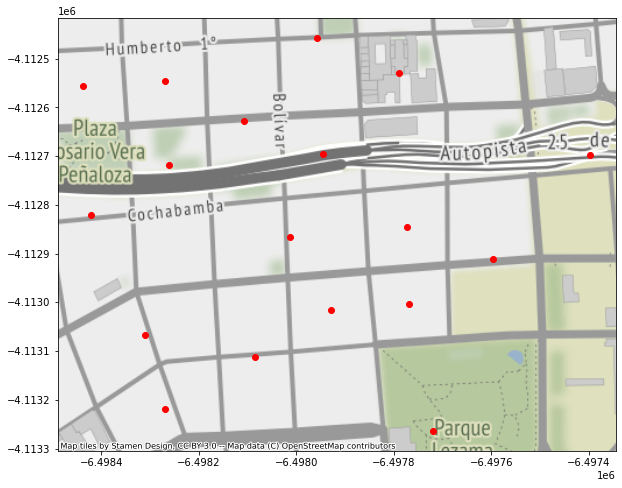

In [39]:
# Chequeo en qué zona están los radios respecto al basemap
ax = prueba_radios.plot(figsize= (10,10), color= 'red')
ctx.add_basemap(ax, zoom=16)

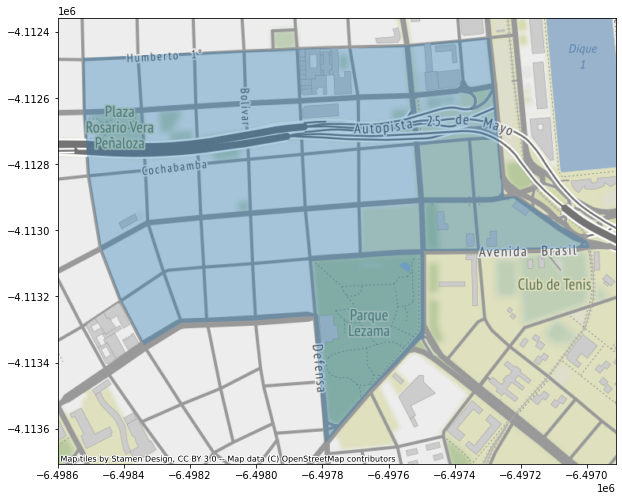

In [40]:
# Chequeo en qué zona está el circuito respecto al basemap

ax2 = prueba_circuitos.plot(figsize= (10,10), alpha= 0.35)
ctx.add_basemap(ax2, zoom= 16)

# Se puede apreciar que los centroides de los radios encajan dentro del contorno del circuito, en San Telmo. 
# Así comprobamos que el sjoin estaba bien hecho

### Plot de radios y circuitos
#### También podemos realizar un plot de cimo encajan los radios en los circuitos

<AxesSubplot:>

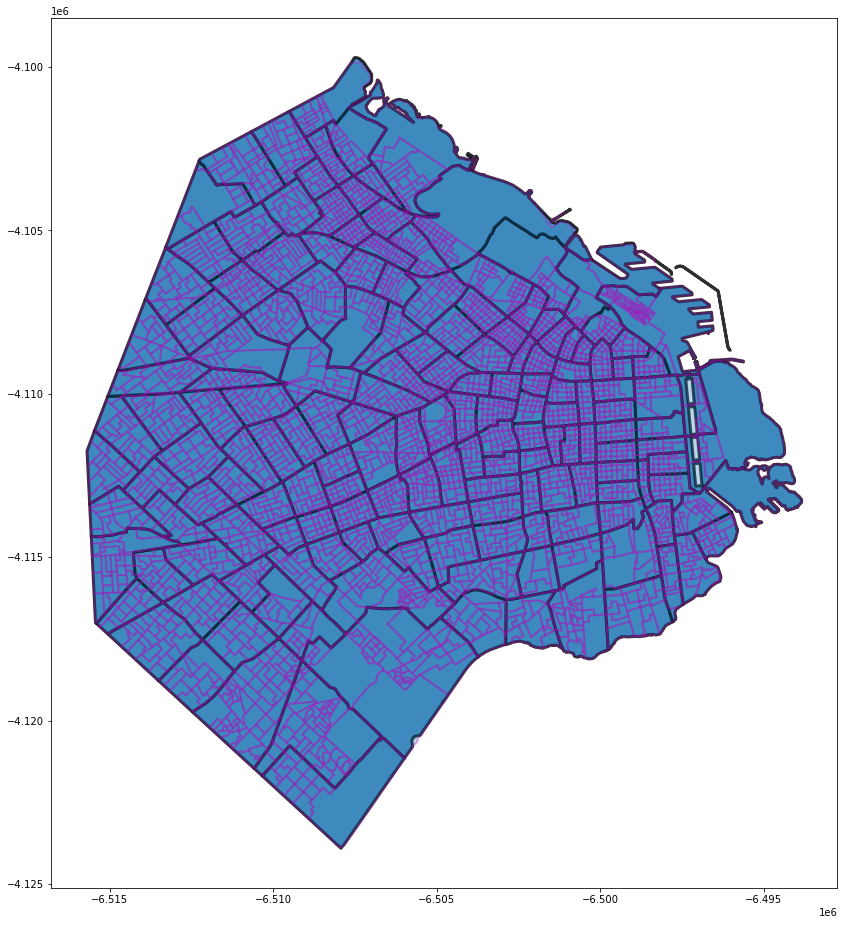

In [43]:
fig, ax = plt.subplots(figsize = (20,16)) 
sub_circuitos.plot(ax=ax, alpha = 0.8, linewidth = 3, edgecolor = 'k')
radios.geometry.plot(color=None,edgecolor='m',linewidth = 2,ax=ax, alpha = 0.3) 

### Exportamos el join a un .csv

In [ ]:
join.to_csv("geom_join.csv")

## Hacemos el join de los datos georreferenciados combinados con elecciones y con censo

### Mergeamos el join.csv con los datos geográficos y el DF de las elecciones

In [52]:
DF_geo_elecciones = pd.merge(join, elec_pres_fit, on="CODIGO_CIRCUITO")

### Mergeamos el join con los datos geográficos y el DF del censo

In [53]:
DF_geo_censo = pd.merge(join, censo_cortado, on="LINK")
DF_geo_censo = DF_geo_censo.drop(columns=["LINK", "index_right", "FRAC_REF_ID", "IDRADIO", "NHOG", "TOTPERS",
                                          "DPTO_REF_ID", "DPTO", "VIVIENDA_REF_ID", "HOGAR_REF_ID", "ALGUNBI",
                                          "IDFRAC", "PROV_REF_ID"], axis=1)



### Mergeamos datos geográficos + elecciones + censo

In [54]:
DF_completo = pd.merge(DF_geo_elecciones, DF_geo_censo, on=["CODIGO_CIRCUITO", "geometry", "centroide"])

### Borramos columnas que no nos sirven

In [55]:
DF_completo = DF_completo.drop(columns=["LINK", "index_right", "NOMDPTO"], axis=1)

### Lo guardamos en un .csv

In [ ]:
DF_completo.to_csv("DF_completo.csv")

# Ya tenemos armado el DataFrame completo con los datos del censo y de las elecciones

# Ahora analizaremos un poco los datos de edad

### Filtramos a los menores de 16 años (los que no pueden votar)

### Gráficamos el promedio de edades por comuna, solo para mayores de 16 años. 
(Todos los ciudadanos que pueden votar, por lo menos si se tiene en cuenta la edad, y no otras variables como ciudadanía)

In [ ]:
DF_16_mas = DF_completo[DF_completo["P03"] > 15]

prom_edad_16mas_comuna = DF_16_mas.groupby(["NOMBRE_REGION"])["P03"].mean().to_frame()
prom_edad_16mas_comuna.to_csv("promedio_edad_comuna_16_para_arriba.csv")


In [ ]:
df = pd.read_csv("promedio_edad_comuna_16_para_arriba.csv")
eje_x = df["NOMBRE_REGION"]
eje_y = df["P03"]
plt.bar(eje_x, eje_y, color="lightcoral")
plt.xticks(rotation=90)
plt.ylabel("Promedio de edad")
plt.title('Promedio de edad por comuna')
plt.ylim(40,48)
plt.show()

 ### Gráfico con promedio de edad por circuito (mayores de 16)

In [ ]:
df = pd.read_csv("/content/Comuna1.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 1: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna2.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 2: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna3.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 3: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna4.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar",color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 4: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna5.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 5: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna6.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 6: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna7.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 7: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna8.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 8: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna9.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 9: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna10.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 10: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna11.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 11: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna12.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 12: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna13.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 13: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna14.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 14: Promedio de edades por circuito electoral')

df = pd.read_csv("/content/Comuna15.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="P03", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Promedio de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 15: Promedio de edades por circuito electoral')

### Mediana de edad por comuna

In [ ]:
# Mediana de edades más 16 por comuna:
mediana_edad_mas16_comuna = DF_16_mas.groupby(["NOMBRE_REGION"])["P03"].median().to_frame()
mediana_edad_mas16_comuna.rename(columns={"P03": "MEDIANA_EDAD"}, inplace= True)
mediana_edad_mas16_comuna.to_csv("mediana_edad_comuna.csv")

In [ ]:
df = pd.read_csv("/content/mediana_edad_comuna.csv")
eje_x = df["NOMBRE_REGION"]
eje_y = df["MEDIANA_EDAD"]
plt.bar(eje_x, eje_y, color="lightcoral")
plt.xticks(rotation=90)
plt.ylabel("Mediana de edad")
plt.title('Mediana de edad por comuna')
plt.ylim(30,48)
plt.show()

### Mediana de edad por circuito electoral

In [ ]:
df = pd.read_csv("/content/Mediana_Comuna1.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 1: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna2.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 2: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna3.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 3: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna4.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 4: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna5.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 5: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna6.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 6: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna7.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 7: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna8.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 8: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna9.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 9: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna10.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 10: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna11.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 11: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna12.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 12: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna13.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 13: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna14.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 14: Mediana de edades por circuito electoral')

df = pd.read_csv("/content/Mediana_Comuna15.csv")
fig2=sns.catplot(data=df, x="CODIGO_CIRCUITO", y="MEDIANA_EDAD", kind="bar", color="lightcoral")
fig2.set_xticklabels(df.CODIGO_CIRCUITO, rotation=90)
plt.ylabel("Mediana de edad")
plt.xlabel ("Circuitos")
plt.title('Comuna 15: Mediana de edades por circuito electoral')